In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import comet_ml
experiment = comet_ml.Experiment(project_name="2019nn_beer")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/aeryen/2019nn-beer/0c03f5d8f60d414c98978d8288ad9e80



In [1]:
# %%
from fastai.text import *
from data_helpers.Data import *
from fastai.text.transform import *

In [2]:
hyper_params = {
    "max_sequence_length": 20*70,
    "batch_size": 32,
    "num_epochs1": 12,
    "num_epochs2": 15,
    "num_aspect": 5,
    "num_rating": 5,
}

In [3]:
experiment.log_parameters(hyper_params)

NameError: name 'experiment' is not defined

# Load LM Databunch and LM Learner

In [6]:
# lm_db = load_data("./data/", "hotel_lm_databunch.1001")
# lm_learn = language_model_learner(lm_db, AWD_LSTM)
# lm_learn = lm_learn.load("lang_model_hotel")

In [7]:
# lm_learn.save_encoder('lang_model_hotel_enc')

In [4]:
cls_db = load_data("./data/", "beer_clas_databunch_rint.TraValTes")
cls_db.batch_size=hyper_params["batch_size"]
cls_db.batch_size

32

In [16]:
x,y = cls_db.one_batch()

In [17]:
x.shape

torch.Size([32, 1347])

In [19]:
y[:10]

tensor([[4., 4., 4., 4., 4.],
        [2., 3., 2., 2., 2.],
        [2., 3., 4., 3., 3.],
        [4., 3., 4., 3., 4.],
        [3., 3., 3., 2., 3.],
        [2., 4., 4., 3., 4.],
        [4., 3., 4., 4., 4.],
        [3., 3., 4., 4., 4.],
        [4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4.]])

# Tools

### Sentence Feature Pooling

In [5]:
def pool_combo(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    max_pool = output[start:end, :].max(dim=0)[0]
    x = torch.cat([output[-1,:], max_pool, avg_pool], 0)
    return x

def sentence_pool_1200(outputs, mask, p_index):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    seq_max = output.size(1)
    doc_start = mask.int().sum(dim=1)
    
    batch = []
    for doci in range(0,output.shape[0]):
        pi = p_index[doci,:].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range( len(pi) ):
            if senti==0:
                doc.append( pool_combo(output[doci,:,:], doc_start[doci], pi[senti]) )
            else:
                doc.append( pool_combo(output[doci,:,:], pi[senti-1]+1, pi[senti]) )
            
        batch.append( torch.stack(doc, 0) )

    return batch

def sentence_pool_400(outputs, mask, p_index):
    output = outputs[-1]
    
    batch = []
    for doci in range(0,output.shape[0]):
        doc = output[doci,p_index[doci,:],:]
        batch.append( doc )

    return batch

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

## DEFINE MODEL

In [6]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder init")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+self.bptt, sl)] == self.period_index )
                
#         print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
#         print(n_sent)
        
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

### Baseline 01: Fastai Default

In [8]:
# experiment.add_tag("base01")

class Base01Module(Module):
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("base01 init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin(1200, 50, p=0.5, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(50, n_asp*n_rat, p=0.1, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        x = masked_concat_pool(outputs, mask)

        sentiment_dist = self.layers(x)
        sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
        
        return sentiment_dist,raw_outputs,outputs

### Baseline 02: Sentence feature (400) extract then estimate distribution, sent. dist. sumed to doc output

In [11]:
experiment.add_tag("base02")

class SimpleSentModule(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("SimpleSentModule init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
#         mod_layers += bn_drop_lin(400, 60, p=0.4, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(400, n_asp*n_rat, p=0, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        # takes only last layer output
        output = outputs[-1] # [batch, seq_len, emb_size]

        result = []
        for bati in range(0,output.shape[0]):
            sent_output = output[bati, p_index[bati,:], :]
            sentiment_dist = self.layers(sent_output)
            sentiment_dist = torch.sum(sentiment_dist, dim=0, keepdim=True)
            sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
            result.append(sentiment_dist)
        
        result = torch.cat( result, dim=0 )
        
        return result,raw_outputs,outputs

### Baseline 03: average sentence combo pool feature then do document BMM

In [ ]:
experiment.add_tag("base03")

class ClsModule1200avg(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        output = outputs[-1] # [batch, seq_len, emb_size]

        # print("number of sentences in docs:")
        n_sent = torch.sum( p_index , dim=1)

        batch = sentence_extract_pool(outputs, mask, p_index)
        doc_list = []
        result = []
        for doci in range(0,output.shape[0]):
            sent_output = batch[doci]
            doc_output = sent_output.mean(dim=0, keepdim=True)
            doc_list.append(doc_output)

        doc_list = torch.cat( doc_list, dim=0 )
        aspect_dist = self.aspect(doc_list)         # [aspect]
        sentiment_dist = self.sentiment(doc_list)   # [sentiment]
        result = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        return result,raw_outputs,outputs

# Building Learner

In [9]:
def get_text_classifier(arch:Callable, vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    print("CUSTOM DEFINED CLASSIFIER")
    meta = text.learner._model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = SentenceEncoder(bptt, max_len, arch(vocab_sz, **config), vocab, pad_idx=pad_idx)
    cls_layer = Base01Module(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"], layers=layers, drops=ps)
    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

In [10]:
def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        print(fnames)
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

## Classification loss and metrics

In [11]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target, nasp=hyper_params["num_aspect"]):
        target = target.long()
        loss = 0
        for i in range(nasp):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

In [12]:
def multi_acc(preds, targs, nasp=hyper_params["num_aspect"], nrat=5):
    preds = preds[:,0:nasp,:]
    preds = preds.contiguous().view(-1, nrat)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [13]:
def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc

In [14]:
def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

## create the objects

In [15]:
macc=[get_clas_acc(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]): macc[ai].__name__ = "clas_acc_"+str(ai)
mmse=[get_clas_mse(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]): mmse[ai].__name__ = "clas_mse_"+str(ai)

In [16]:
mloss = MultiLabelCEL()
# mloss = MultiLabelMSE()
cls_learn = text_classifier_learner(cls_db, AWD_LSTM, 
                                    loss_func=mloss,
                                    metrics=[multi_acc]+macc+mmse,
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"])

CUSTOM DEFINED CLASSIFIER
Encoder init
base01 init
Num Aspect: 5
Num Rating: 5
[PosixPath('/home/aeryen/.fastai/models/wt103-fwd/lstm_fwd.pth'), PosixPath('/home/aeryen/.fastai/models/wt103-fwd/itos_wt103.pkl')]
FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Base01Module(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace

In [20]:
_=cls_learn.load_encoder('lm_enc_beer.1115')

FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Base01Module(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=25, bias=True)
    )
  )
)

# Train log

## BASE 01

In [21]:
with experiment.train():
    cls_learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.965792,4.524176,0.585059,0.582828,0.555248,0.631382,0.579704,0.576134,0.547572,0.517583,0.467155,0.510264,0.533113,01:42
1,4.811499,4.475307,0.584863,0.583006,0.549000,0.629954,0.581310,0.581042,0.538736,0.512406,0.470100,0.503124,0.528829,01:41
2,4.866889,4.472421,0.585684,0.577829,0.552481,0.629240,0.580328,0.588540,0.554266,0.502231,0.476705,0.495359,0.517137,01:36
3,4.867322,4.457306,0.588343,0.588629,0.550161,0.636737,0.578186,0.588004,0.527758,0.505444,0.452606,0.483310,0.516066,01:44
4,4.824244,4.432539,0.592342,0.588629,0.558372,0.632899,0.589611,0.592199,0.523117,0.535791,0.447876,0.497144,0.509818,01:43
5,4.796693,4.438394,0.589486,0.588718,0.558015,0.631025,0.583899,0.585773,0.517047,0.500536,0.450286,0.487504,0.518654,01:43


KeyboardInterrupt: 

{'web': 'https://www.comet.ml/api/image/download?imageId=f424c26ee10d450eb3d0963a0c3caef0&experimentKey=0c03f5d8f60d414c98978d8288ad9e80',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=f424c26ee10d450eb3d0963a0c3caef0&experimentKey=0c03f5d8f60d414c98978d8288ad9e80',
 'imageId': 'f424c26ee10d450eb3d0963a0c3caef0'}

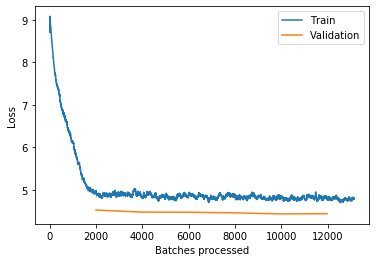

In [22]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [23]:
cls_learn.save('beer.clas.base01.1.learner')

In [20]:
cls_learn.load('beer.clas.base01.1.learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8969 items)
x: TextList
xxbos we had the most wonderful time at the excellence xxperiod we opted for the excellence club and it was well worht it for the perks xxperiod roberto puello who was the club manager did an extra special job of making us feel welcomed xxperiod we took some great pictures that looked like postcards xxperiod the food was excellent the pizza was close to being our favorite xxperiod the shows were great especially the michael jackson and the 70 's 80 's night xxperiod the french resturant was probably our favorite xxperiod we will definately be back for an anniversary trip xxperiod we made some friends but had plenty of xxunk as well xxperiod the rooms were great and everytime we left and came back it was cleaned , towels restocked and the bar was as well xxperiod,xxbos too sick to enjoy the ride to and form the airport is not good xxperiod very bumpy road and you can really see the poor living conditions xxper

In [24]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Base01Module(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=25, bias=True)

In [25]:
with experiment.train():
    cls_learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.601430,4.331111,0.601571,0.602463,0.567297,0.648072,0.596037,0.593984,0.513656,0.500000,0.434220,0.496608,0.506694,03:45
1,4.600609,4.228543,0.611924,0.613263,0.588897,0.652803,0.605052,0.599607,0.482506,0.456890,0.419047,0.468136,0.483845,03:51
2,4.368520,4.135220,0.622510,0.622546,0.604070,0.662085,0.608265,0.615584,0.470903,0.439397,0.411996,0.467779,0.476437,03:56
3,4.332958,4.047858,0.629846,0.628526,0.608800,0.663692,0.621564,0.626651,0.458675,0.444216,0.401107,0.442342,0.438683,03:57
4,4.214263,4.003508,0.635380,0.629864,0.615316,0.670207,0.631828,0.629686,0.462335,0.446537,0.402624,0.427526,0.455819,03:57
5,4.105588,3.969107,0.640754,0.634506,0.617904,0.679400,0.637808,0.634149,0.453499,0.426633,0.376919,0.426455,0.421724,03:56
6,4.108805,3.943114,0.642753,0.638611,0.620225,0.678329,0.638076,0.638522,0.434131,0.432881,0.373706,0.418690,0.429936,03:42
7,4.042294,3.925182,0.644431,0.638254,0.622813,0.681185,0.641110,0.638790,0.441182,0.424313,0.375848,0.416548,0.427794,03:42
8,3.997662,3.922192,0.643502,0.636737,0.622635,0.680025,0.639861,0.638254,0.436808,0.424134,0.375134,0.418243,0.425830,03:45
9,3.965235,3.921481,0.643966,0.638076,0.620939,0.680918,0.641378,0.638522,0.441360,0.428508,0.378793,0.416012,0.430739,03:58


{'web': 'https://www.comet.ml/api/image/download?imageId=59fa57fe870044ab9925ce14dda808bf&experimentKey=0c03f5d8f60d414c98978d8288ad9e80',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=59fa57fe870044ab9925ce14dda808bf&experimentKey=0c03f5d8f60d414c98978d8288ad9e80',
 'imageId': '59fa57fe870044ab9925ce14dda808bf'}

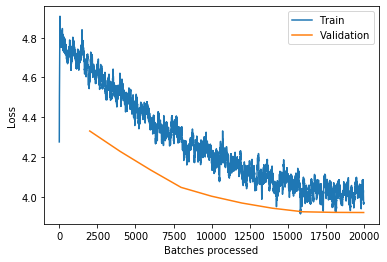

In [26]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [27]:
cls_learn.save('beer.clas.base01.2.learner')

# load test text

In [32]:
sent_num_file = ["train.count", "test.count"]
rating_file = ["train.rating", "test.rating"]
content_file = ["train.txt", "test.txt"]

dataset_dir = "./data/beer_100k/"

In [33]:
# TRAIN_DATA = 0
TEST_DATA = 1

In [36]:
# Load Ratings
aspect_rating_test = list(open(dataset_dir + rating_file[TEST_DATA], "r").readlines())
aspect_rating_test = [s for s in aspect_rating_test if (len(s) > 0 and s != "\n")]

aspect_rating_test = [s.split(" ") for s in aspect_rating_test]
aspect_rating_test = np.array(aspect_rating_test)[:, :]
aspect_rating_test = aspect_rating_test.astype(np.float) - 1
aspect_rating_test = np.rint(aspect_rating_test).astype(int)  # ROUND TO INTEGER =================
aspect_rating_test = pd.DataFrame(aspect_rating_test)
print( aspect_rating_test.head() )

   0  1  2  3  4
0  3  3  4  3  4
1  2  2  2  2  2
2  3  3  3  2  3
3  3  2  2  2  4
4  2  2  2  2  2


In [37]:
target = torch.tensor( aspect_rating_test.values )
target

tensor([[3, 3, 4, 3, 4],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 2, 3],
        ...,
        [4, 2, 4, 3, 4],
        [2, 2, 1, 0, 3],
        [3, 2, 4, 2, 4]])

# Test output

In [38]:
preds = cls_learn.get_preds(ds_type=DatasetType.Test)
preds[0].shape

torch.Size([24884, 5, 5])

In [31]:
#torch.argmax(asps[0],dim=1)

In [33]:
mloss = MultiLabelCEL()
mloss.forward( preds[0] , target)

tensor(6.0654)

In [40]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_acc(ai)(preds[0], target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.634584,0.623091,0.676901,0.633098,0.631892


In [41]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_mse(ai)(preds[0], target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.440604,0.433652,0.376266,0.421677,0.43526


# FINISH EXPR

In [42]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/aeryen/2019nn-beer/0c03f5d8f60d414c98978d8288ad9e80
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                   : (2.2, 2.2)
COMET INFO:     sys.cpu.percent.02                   : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.03                   : (0.9, 0.9)
COMET INFO:     sys.cpu.percent.04                   : (0.0, 0.0)
COMET INFO:     sys.cpu.percent.05                   : (0.0, 0.0)
COMET INFO:     sys.cpu.percent.06                   : (0.0, 0.0)
COMET INFO:     sys.cpu.percent.07                   : (2.7, 2.7)
COMET INFO:     sys.cpu.percent.08                   : (0.5, 0.5)
COMET INFO:     sys.cpu.percent.09                   : (0.0, 0.0)
COMET INFO:     sys.cpu.percent.10                   : (12.4, 12.4)
COMET INFO:     sys.cpu.percent.11                   : (0.4, 0.4)
COMET INFO:     sys.cpu.percent.12